# Neo4j x LLM example: Asset Manager

### Purpose
This notebook serves as a comprehensive example of how Neo4j and Language Models for Less (LLMs) can synergize to offer advanced capabilities. It demonstrates the integration of Neo4j with Google's Vertex AI Language Models to accomplish the following tasks:

1. **Data Loading**: Import semi-structured data to create relationships between (:Asset Manager) and (:Company) entities.
2. **Cypher Queries**: Learn how to write and execute basic Cypher queries to manipulate and query the graph database.
3. **Natural Language to Cypher**: Utilize langchain and GraphCypherQAChain to translate natural language queries into Cypher queries, run the queries on the database and summarize the results in english for question-answering (QA) applications.
4. **Chatbot Interface**: Deploy a chatbot interface using gradio to interact with the graph database.
5. **Deep Semantic Search**: Implement vector-based indexing to perform deep semantic searches on the Knowledge Graph (KG).
6. **Graph Data Science (GDS) Similarity**: Utilize Neo4j's Graph Data Science library to compute new relationships from similarities among graph nodes.

This notebook is modular and can be divided into separate demos to focus on specific functionalities if needed.

## Source and Data
This demo is a summary of the [hands-on-lab-neo4j-and-vertex-ai](
https://github.com/neo4j-partners/hands-on-lab-neo4j-and-vertex-ai). Original data can be downloaded following these [instructions](https://github.com/neo4j-partners/neo4j-sec-edgar).


## Requirements

To fully utilize this notebook, you will need:

- A Google Cloud Platform (GCP) account
- Access to Google's Vertex AI services
- Access to a Neo4j instance (Version 5.11 or higher for vectorIndex functionality). Restore [this database dump](https://drive.google.com/file/d/1qKvbpVKMZGonYBGGjs36Zf4PzxUZwuaz/view?usp=drive_link).
- Neo4j's Graph Data Science library for similarity computations

Please follow the setup instructions provided in the subsequent sections to configure your environment.

In [1]:
# Your GCP project
project_id = 'Your-GCP-project-id'
location = 'us-central1'

## Setup

In [ ]:
#!pip install --user graphdatascience
#!pip install --user langchain  # library for combining functional steps around LLM calls
#!pip install --user google-cloud-aiplatform  # library for accessing VertexAI
#!pip install --user gradio  # for building the chat interface
#!pip install --user numpy

In [ ]:
#!gcloud auth login
#!gcloud auth application-default login

In [2]:
from google.cloud import aiplatform
import pandas as pd
import json

aiplatform.init(project=project_id)

In [3]:
from langchain.chains import GraphCypherQAChain, LLMChain
from langchain.graphs import Neo4jGraph
from langchain.llms import VertexAI
from langchain.prompts.prompt import PromptTemplate

In [4]:
base_chain = VertexAI(model_name="text-bison@001", temperature=0)

cloudpickle is not installed. Please call `pip install google-cloud-aiplatform[preview]`.


### Prompt Definition
In the upcoming sections, we will extract knowledge adhering to the following schema. This is a very Simplified schema to denote investment management entities and companies they own through common stock. Normally, you will have Domain Experts who come up with a richer data model, and you can extend the below to work on more data/forms to fill such a model.

To achieve our Extraction goal as per the schema, We will use a series of prompts, each focused on only one task - to extract a specific entity. By this way, you can go for more granular extraction. The prompts I used here can be improved and in production scenario, you should consider running QA on the prompt pipelines to ensure that the extracted information is correct.

Let's go in this order to gather the data in accordance to out data model:

1. Extract Manager Information
2. Extract Filing Information

In [5]:
mgr_info_tpl = """From the text below, extract the following as json. Do not miss any of these information.
* The tags mentioned below may or may not namespaced. So extract accordingly. Eg: <ns1:tag> is equal to <tag>
* "name" - The name from the <name> tag under <filingManager> tag
* "street1" - The manager's street1 address from the <com:street1> tag under <address> tag
* "street2" - The manager's street2 address from the <com:street2> tag under <address> tag
* "city" - The manager's city address from the <com:city> tag under <address> tag
* "stateOrCounty" - The manager's stateOrCounty address from the <com:stateOrCountry> tag under <address> tag
* "zipCode" - The manager's zipCode from the <com:zipCode> tag under <address> tag
* "reportCalendarOrQuarter" - The reportCalendarOrQuarter from the <reportCalendarOrQuarter> tag under <address> tag
* Just return me the JSON enclosed by 3 backticks. No other text in the response

Text:
$ctext
"""

In [6]:
filing_info_tpl = """The text below contains a list of investments. Each instance of <infoTable> tag represents a unique investment. 
For each investment, please extract the below variables into json then combine into a list enclosed by 3 back ticks. Please use the quated names below while doing this
* "cusip" - The cusip from the <cusip> tag under <infoTable> tag
* "companyName" - The name under the <nameOfIssuer> tag.
* "value" - The value from the <value> tag under <infoTable> tag. Return as a number. 
* "shares" - The sshPrnamt from the <sshPrnamt> tag under <infoTable> tag. Return as a number. 
* "sshPrnamtType" - The sshPrnamtType from the <sshPrnamtType> tag under <infoTable> tag
* "investmentDiscretion" - The investmentDiscretion from the <investmentDiscretion> tag under <infoTable> tag
* "votingSole" - The votingSole from the <votingSole> tag under <infoTable> tag
* "votingShared" - The votingShared from the <votingShared> tag under <infoTable> tag
* "votingNone" - The votingNone from the <votingNone> tag under <infoTable> tag

Text:
$ctext
"""

### Functions for Using LLMs
Let's create some helper function to talk to the LLM with our prompt and text input. We will use the text-bison base model. In your use case, you might need to tune it. VertexAI provides an elegant way to finetune it. The weights will be staying within your tenant and the base model is frozen.

First off, you'll need to set your project_id.

In [8]:
# wrapper for calling language model
def run_text_model(
    project_id: str,
    model_name: str,
    temperature: float,
    max_decode_steps: int,
    top_p: float,
    top_k: int,
    prompt: str,
    location: str = location,
    tuned_model_name: str = None,
    ) :
    """Text Completion Use a Large Language Model."""
    vertexai.init(project=project_id, location=location)
    if tuned_model_name is None:
        model = TextGenerationModel.from_pretrained(model_name)
    else:
        model = model.get_tuned_model(tuned_model_name)
    response = model.predict(
        prompt,
        temperature=temperature,
        max_output_tokens=max_decode_steps,
        top_k=top_k,
        top_p=top_p,)
    return response.text

In [9]:
# wrapper for entity extraction / parsing
def extract_entities_relationships(prompt, tuned_model_name=None):
    try:
        res = run_text_model(project_id, "text-bison@001", 0, 1024, 0.8, 1, prompt, location, tuned_model_name)
        return res
    except Exception as e:
        print(e)

In [10]:
# splitting function for chunking up filing information to avoid hitting LLM token limits
import re
import numpy as np

def split_filing_info(s, chunk_size=5):
    pattern = '(</(\w+:)?infoTable>)'
    splitter = re.findall(pattern, s)[0][0]
    _parts = s.split(splitter)
    if len(_parts) > chunk_size:
        chunks_of_list = np.array_split(_parts, len(_parts)/chunk_size) # max 5 filings per part
        chunks_of_str = map(lambda x: splitter.join(x), chunks_of_list)
        return list(chunks_of_str)
    else:
        return [s]

### Test Example for Parsing
Let's start with one Form 13 file to see how we can parse it with generative AI.

In [12]:
import requests

url = 'https://drive.google.com/uc?export=download&id=1OXdyCcZVgIpEPCoBtAe7-a1_0Y2I3Xpc'

response = requests.get(url)

# Ensure the request was successful
response.raise_for_status()

# Get the text content
inp_text = response.text

## Demo: Asset Manager Example

Run cells above

In this notebook, let's explore how to leverage Google Generative AI to build and consume a knowledge graph in Neo4j.

This notebook parses Form-13 data From SEC EDGAR. The Form 13 files are semi structured data that are pretty nasty to parse. We'll use generative AI to do it for us. We will then also use the LLM to generate Cypher statments to load the extracted data into a Neo4j graph. Then, we'll use a chatbot to query the knowledge graph we've created.

Questions you want to ask:

- **Which fund manager owns most companies? How many shares?**
- **What are the top 10 investments for Vanguard?**
- **What are the other top investments for fund managers investing in Apple?**



In [13]:
# Shows the file we are going to parse.
print(inp_text)

<SEC-DOCUMENT>0000919574-23-003245.txt : 20230515
<SEC-HEADER>0000919574-23-003245.hdr.sgml : 20230515
<ACCEPTANCE-DATETIME>20230515103943
ACCESSION NUMBER:		0000919574-23-003245
CONFORMED SUBMISSION TYPE:	13F-HR
PUBLIC DOCUMENT COUNT:		2
CONFORMED PERIOD OF REPORT:	20230331
FILED AS OF DATE:		20230515
DATE AS OF CHANGE:		20230515
EFFECTIVENESS DATE:		20230515

FILER:

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			TIGER MANAGEMENT L.L.C.
		CENTRAL INDEX KEY:			0001027451
		IRS NUMBER:				000000000
		STATE OF INCORPORATION:			DE

	FILING VALUES:
		FORM TYPE:		13F-HR
		SEC ACT:		1934 Act
		SEC FILE NUMBER:	028-05892
		FILM NUMBER:		23919492

	BUSINESS ADDRESS:	
		STREET 1:		101 PARK AVENUE
		CITY:			NEW YORK
		STATE:			NY
		ZIP:			10178
		BUSINESS PHONE:		212-984-2500

	MAIL ADDRESS:	
		STREET 1:		101 PARK AVENUE
		CITY:			NEW YORK
		STATE:			NY
		ZIP:			10178

	FORMER COMPANY:	
		FORMER CONFORMED NAME:	TIGER MANAGEMENT LLC/NY
		DATE OF NAME CHANGE:	20010606
</SEC-HEADER>
<DOCUMENT>
<TYPE>

In [14]:
# Split the file into manager_info and filing_info 
contents = inp_text.split('<XML>')
manager_info = contents[1].split('</XML>')[0].strip()
filing_info = contents[2].split('</XML>')[0].strip()

### Parsing Manager Information

In [15]:
# Shows the prompt that will be feed to the LLM

from string import Template

prompt = Template(mgr_info_tpl).substitute(ctext=manager_info)
print(prompt)

From the text below, extract the following as json. Do not miss any of these information.
* The tags mentioned below may or may not namespaced. So extract accordingly. Eg: <ns1:tag> is equal to <tag>
* "name" - The name from the <name> tag under <filingManager> tag
* "street1" - The manager's street1 address from the <com:street1> tag under <address> tag
* "street2" - The manager's street2 address from the <com:street2> tag under <address> tag
* "city" - The manager's city address from the <com:city> tag under <address> tag
* "stateOrCounty" - The manager's stateOrCounty address from the <com:stateOrCountry> tag under <address> tag
* "zipCode" - The manager's zipCode from the <com:zipCode> tag under <address> tag
* "reportCalendarOrQuarter" - The reportCalendarOrQuarter from the <reportCalendarOrQuarter> tag under <address> tag
* Just return me the JSON enclosed by 3 backticks. No other text in the response

Text:
<?xml version="1.0" encoding="UTF-8"?>
<edgarSubmission xsi:schemaLocati

In [17]:
import json
import vertexai
vertexai.init(project=project_id, location=location)
from vertexai.language_models import TextGenerationModel

response = extract_entities_relationships(prompt)
manager_data = json.loads(response.split('```')[1].strip('json'))

manager_data


{'name': 'TIGER MANAGEMENT L.L.C.',
 'street1': '101 PARK AVENUE',
 'street2': '',
 'city': 'NEW YORK',
 'stateOrCounty': 'NY',
 'zipCode': '10178',
 'reportCalendarOrQuarter': '03-31-2023'}

### Parse Filing Information
We will parse filing info in a similar manner to manager information. Because the filings include a list of many entries however, we will want to split the input into chunks so as not to exceed input or output token limits.

In [18]:
filing_info_chunks = split_filing_info(filing_info)
len(filing_info_chunks)

6

In [19]:
prompt = Template(filing_info_tpl).substitute(ctext=filing_info_chunks[0])
print(prompt)

The text below contains a list of investments. Each instance of <infoTable> tag represents a unique investment. 
For each investment, please extract the below variables into json then combine into a list enclosed by 3 back ticks. Please use the quated names below while doing this
* "cusip" - The cusip from the <cusip> tag under <infoTable> tag
* "companyName" - The name under the <nameOfIssuer> tag.
* "value" - The value from the <value> tag under <infoTable> tag. Return as a number. 
* "shares" - The sshPrnamt from the <sshPrnamt> tag under <infoTable> tag. Return as a number. 
* "sshPrnamtType" - The sshPrnamtType from the <sshPrnamtType> tag under <infoTable> tag
* "investmentDiscretion" - The investmentDiscretion from the <investmentDiscretion> tag under <infoTable> tag
* "votingSole" - The votingSole from the <votingSole> tag under <infoTable> tag
* "votingShared" - The votingShared from the <votingShared> tag under <infoTable> tag
* "votingNone" - The votingNone from the <votingN

In [20]:
response = extract_entities_relationships(prompt)
print(response)

  ```
[
  {
    "cusip": "02079K305",
    "companyName": "ALPHABET INC",
    "value": 1488692,
    "shares": 14352,
    "sshPrnamtType": "SH",
    "investmentDiscretion": "SOLE",
    "votingSole": 14352,
    "votingShared": 0,
    "votingNone": 0
  },
  {
    "cusip": "023135106",
    "companyName": "AMAZON COM INC",
    "value": 582556,
    "shares": 5640,
    "sshPrnamtType": "SH",
    "investmentDiscretion": "SOLE",
    "votingSole": 5640,
    "votingShared": 0,
    "votingNone": 0
  },
  {
    "cusip": "049468101",
    "companyName": "ATLASSIAN CORPORATION",
    "value": 205404,
    "shares": 1200,
    "sshPrnamtType": "SH",
    "investmentDiscretion": "SOLE",
    "votingSole": 1200,
    "votingShared": 0,
    "votingNone": 0
  },
  {
    "cusip": "053332102",
    "companyName": "AUTOZONE INC",
    "value": 9218063,
    "shares": 3750,
    "sshPrnamtType": "SH",
    "investmentDiscretion": "SOLE",
    "votingSole": 3750,
    "votingShared": 0,
    "votingNone": 0
  },
  {
    "cusi

### Data Ingestion - Test Example
Let's walk through the steps to do this with just the 1 form above first, then we can move on to parsing and ingesting all the Form 13s.

To start, we can run the LLM parsing over all the filing info from the form then combine the resulting json into a list condusive for Neo4j loading.

In [21]:
filings_list = []
for filing_info_chunk in filing_info_chunks:
    prompt = Template(filing_info_tpl).substitute(ctext=filing_info_chunk)
    response = extract_entities_relationships(prompt)
    filings_list.extend(json.loads(response.replace('```', '')))

for item in filings_list:
    item['managerName'] = manager_data['name']
    item['reportCalendarOrQuarter'] = manager_data['reportCalendarOrQuarter']
filings_list[:5]

[{'cusip': '02079K305',
  'companyName': 'ALPHABET INC',
  'value': 1488692,
  'shares': 14352,
  'sshPrnamtType': 'SH',
  'investmentDiscretion': 'SOLE',
  'votingSole': 14352,
  'votingShared': 0,
  'votingNone': 0,
  'managerName': 'TIGER MANAGEMENT L.L.C.',
  'reportCalendarOrQuarter': '03-31-2023'},
 {'cusip': '023135106',
  'companyName': 'AMAZON COM INC',
  'value': 582556,
  'shares': 5640,
  'sshPrnamtType': 'SH',
  'investmentDiscretion': 'SOLE',
  'votingSole': 5640,
  'votingShared': 0,
  'votingNone': 0,
  'managerName': 'TIGER MANAGEMENT L.L.C.',
  'reportCalendarOrQuarter': '03-31-2023'},
 {'cusip': '049468101',
  'companyName': 'ATLASSIAN CORPORATION',
  'value': 205404,
  'shares': 1200,
  'sshPrnamtType': 'SH',
  'investmentDiscretion': 'SOLE',
  'votingSole': 1200,
  'votingShared': 0,
  'votingNone': 0,
  'managerName': 'TIGER MANAGEMENT L.L.C.',
  'reportCalendarOrQuarter': '03-31-2023'},
 {'cusip': '053332102',
  'companyName': 'AUTOZONE INC',
  'value': 9218063,


In [22]:
len(filings_list)


33

### Establish Neo4j Connection

Now, we're going to load data into Neo4j. To do so, you will, of course, need a Neo4j instance. The easiest way to get started with Neo4j on Google Cloud is with Aura, the Neo4j managed service. That comes in a few flavors, various combinations of Professional and Enterprise, conflated with DB and DS. Those stand for database and data science. The data science version includes the database as well.

In [23]:
# Credentials
NEO4J_URI = 'bolt://localhost:7687'
NEO4J_PASSWORD = 'password'
NEO4J_USERNAME = 'neo4j'

Now, let's create a connection to the database using the Graph Data Science API.

In [24]:
from graphdatascience import GraphDataScience

gds = GraphDataScience(
    NEO4J_URI,
    auth=(NEO4J_USERNAME, NEO4J_PASSWORD),
    aura_ds=False
)
gds.run_cypher(""" CREATE OR REPLACE DATABASE empty """)
gds.set_database('empty')

Before loading we should create uniqueness constraints for nodes. This acts as a unique id and an index and is necessary for fast, efficient, queries. In general, if you notice ingestion is super slow (and getting slower) with Neo4j, double check that you created indexes. For this small sample it won't matter, but it will certainly imact as we ingest more data

In [25]:
gds.run_cypher('''CREATE CONSTRAINT unique_company_id IF NOT EXISTS FOR (p:Company) REQUIRE (p.cusip) IS NODE KEY;''')
gds.run_cypher('''CREATE CONSTRAINT unique_manager IF NOT EXISTS FOR (p:Manager) REQUIRE (p.managerName) IS NODE KEY;''')

""


To Merge in the data we can use parameterized cypher queries. Basically we are going to send filings in batches (in this sample case just one batch) for each node and relationship type and insert them as parameters in the query.

In [26]:
# Create Company Nodes

gds.run_cypher('''
UNWIND $records AS record
MERGE (c:Company {cusip: record.cusip})
SET c.name = record.companyName
RETURN count(c) AS company_node_merge_count
''', params={'records':filings_list})

,company_node_merge_count
0,33


In [27]:
# Create Manager Node. In this case we just have one

gds.run_cypher('''
MERGE (m:Manager {managerName: $managerName})
''', params={'managerName':manager_data['name']})

manager_data['name']

'TIGER MANAGEMENT L.L.C.'

In [28]:
# Create OWNS Relationship

gds.run_cypher('''
UNWIND $records AS record
MATCH (m:Manager {managerName: record.managerName})
MATCH (c:Company {cusip: record.cusip})
MERGE(m)-[r:OWNS]->(c)
SET r.reportCalendarOrQuarter = record.reportCalendarOrQuarter,
    r.value = record.value,
    r.shares = record.shares
RETURN count(r) AS owns_relationship_merge_count
''', params={'records':filings_list})

,owns_relationship_merge_count
0,33


Show in browser:
CALL db.schema.visualization


## More data

We showed how to load data with the LLM. On a large amount of data, it can take a while. 

We did it already, the result is in the 'neo4j' database. Let's see what kind of insights we can get from this graph.

In [29]:
gds.set_database('neo4j')

In [30]:
d = gds.run_cypher("""
CALL apoc.meta.stats()
YIELD labels
""")
pd.DataFrame([d.labels[0]])

,Company,Manager,Document
0,15828,6027,10532


In [31]:
d = gds.run_cypher("""
CALL apoc.meta.stats()
YIELD relTypesCount
""")
pd.DataFrame([d.relTypesCount[0]])

,OWNS,HAS
0,1600322,13102


Cypher examples

In [32]:
# Which fund manager owns most companies?
gds.run_cypher("""             
MATCH (m:Manager) -[o:OWNS]-> (c:Company) 
RETURN m.managerName as manager, count(distinct c) as ownedCompanies 
ORDER BY ownedCompanies 
DESC LIMIT 10
               
""")


,manager,ownedCompanies
0,"JANE STREET GROUP, LLC",6602
1,NORTHERN TRUST CORP,4630
2,"GROUP ONE TRADING, L.P.",4305
3,AMERIPRISE FINANCIAL INC,3943
4,MORGAN STANLEY,3214
5,Bank of New York Mellon Corp,3123
6,UBS Group AG,3121
7,VANGUARD GROUP INC,3093
8,BlackRock Inc.,3069
9,"GEODE CAPITAL MANAGEMENT, LLC",3056


In [33]:
# Which fund manager owns most companies? How many shares?
gds.run_cypher("""
MATCH (m:Manager) -[o:OWNS]-> (c:Company) 
RETURN m.managerName as manager, count(distinct c) as ownedCompanies, sum(distinct o.shares) as ownedShares 
ORDER BY ownedCompanies 
DESC LIMIT 10
""")

,manager,ownedCompanies,ownedShares
0,"JANE STREET GROUP, LLC",6602,5882309199
1,NORTHERN TRUST CORP,4630,18035814010
2,"GROUP ONE TRADING, L.P.",4305,1235996047
3,AMERIPRISE FINANCIAL INC,3943,10907986440
4,MORGAN STANLEY,3214,17792315970
5,Bank of New York Mellon Corp,3123,12445732175
6,UBS Group AG,3121,4211091820
7,VANGUARD GROUP INC,3093,117017424303
8,BlackRock Inc.,3069,100005609173
9,"GEODE CAPITAL MANAGEMENT, LLC",3056,21303109714


In [34]:
# What are the top 10 investments for Vanguard?
gds.run_cypher('''
MATCH (m:Manager) -[o:OWNS]-> (c:Company) 
WHERE m.managerName ="VANGUARD GROUP INC" 
RETURN c.companyName as Investment, sum(DISTINCT o.shares) as totalShares, sum(DISTINCT o.value) as investmentValue 
order by investmentValue 
desc limit 10
''')


,Investment,totalShares,investmentValue
0,Apple Inc,3860414801,3.822425e+14
1,MICROSOFT CORP,1926420210,3.415272e+14
2,AMAZON COM INC,2136779387,1.345882e+14
3,NVIDIA CORPORATION,614004534,8.705039e+13
4,UNITEDHEALTH GROUP INC,251355629,8.445991e+13
5,EXXON MOBIL CORP,1130328265,8.378372e+13
6,Johnson & Johnson,739081679,8.191370e+13
7,JPMORGAN CHASE & CO,822521175,7.273738e+13
8,TESLA INC,651504443,7.266253e+13
9,PROCTER AND GAMBLE CO,675742976,6.776109e+13


In [35]:
# What are the other top investments for fund managers investing in Apple?
gds.run_cypher('''
MATCH (c1:Company) <-[:OWNS]- (m1:Manager) -[o:OWNS]-> (c2:Company) 
WHERE c1.companyName ="Apple Inc" AND elementId(c1) <> elementId(c2) 
RETURN DISTINCT c2.companyName as company, sum(o.value) as totalInvested, sum(o.shares) as totalShares 
ORDER BY totalInvested 
DESC LIMIT 10
''')


,company,totalInvested,totalShares
0,MICROSOFT CORP,7.158068e+15,56733104737
1,AMAZON COM INC,3.069410e+15,62384490669
2,UNITEDHEALTH GROUP INC,2.066209e+15,10611961620
3,NVIDIA CORPORATION,1.923504e+15,19431047745
4,Johnson & Johnson,1.604251e+15,24372178278
5,TESLA INC,1.579323e+15,15075832718
6,JPMORGAN CHASE & CO,1.512149e+15,26075975476
7,EXXON MOBIL CORP,1.482869e+15,25266218807
8,ABBVIE INC,1.360051e+15,10168433941
9,Chevron Corporation,1.308293e+15,13657504944


## Cypher Generation

We have to use a prompt template that clearly states what schema to use, the principles that the chatbot should follow in generating responses, and some few-shot examples to help the chatbot be more accurate in its query generation.

In [36]:
#prompt/template 
CYPHER_GENERATION_TEMPLATE = """You are an expert Neo4j Cypher translator who understands the question in english and convert to Cypher strictly based on the Neo4j Schema provided and following the instructions below:
1. Generate Cypher query compatible ONLY for Neo4j Version 5
2. Do not use EXISTS, SIZE keywords in the cypher. Use alias when using the WITH keyword
3. Please do not use same variable names for different nodes and relationships in the query.
4. Use only Nodes and relationships mentioned in the schema
5. Always enclose the Cypher output inside 3 backticks
6. Always do a case-insensitive and fuzzy search for any properties related search. Eg: to search for a Company name use `toLower(c.name) contains 'neo4j'`
7. Candidate node is synonymous to Manager
8. Always use aliases to refer the node in the query
9. 'Answer' is NOT a Cypher keyword. Answer should never be used in a query.
10. Please generate only one Cypher query per question. 
11. Cypher is NOT SQL. So, do not mix and match the syntaxes.
12. Every Cypher query always starts with a MATCH keyword.

Schema:
{schema}
Samples:
Question: Which fund manager owns most shares? What is the total portfolio value?
Answer: MATCH (m:Manager) -[o:OWNS]-> (c:Company) RETURN m.managerName as manager, sum(distinct o.shares) as ownedShares, sum(o.value) as portfolioValue ORDER BY ownedShares DESC LIMIT 10

Question: Which fund manager owns most companies? How many shares?
Answer: MATCH (m:Manager) -[o:OWNS]-> (c:Company) RETURN m.managerName as manager, count(distinct c) as ownedCompanies, sum(distinct o.shares) as ownedShares ORDER BY ownedCompanies DESC LIMIT 10

Question: What are the top 10 investments for Vanguard?
Answer: MATCH (m:Manager) -[o:OWNS]-> (c:Company) WHERE toLower(m.managerName) contains "vanguard" RETURN c.companyName as Investment, sum(DISTINCT o.shares) as totalShares, sum(DISTINCT o.value) as investmentValue order by investmentValue desc limit 10

Question: What other fund managers are investing in same companies as Vanguard?
Answer: MATCH (m1:Manager) -[:OWNS]-> (c1:Company) <-[o:OWNS]- (m2:Manager) WHERE toLower(m1.managerName) contains "vanguard" AND elementId(m1) <> elementId(m2) RETURN m2.managerName as manager, sum(DISTINCT o.shares) as investedShares, sum(DISTINCT o.value) as investmentValue ORDER BY investmentValue LIMIT 10

Question: What are the top investors for Apple?
Answer: MATCH (m1:Manager) -[o:OWNS]-> (c1:Company) WHERE toLower(c1.companyName) contains "apple" RETURN distinct m1.managerName as manager, sum(o.value) as totalInvested ORDER BY totalInvested DESC LIMIT 10

Question: What are the other top investments for fund managers investing in Apple?
Answer: MATCH (c1:Company) <-[:OWNS]- (m1:Manager) -[o:OWNS]-> (c2:Company) WHERE toLower(c1.companyName) contains "apple" AND elementId(c1) <> elementId(c2) RETURN DISTINCT c2.companyName as company, sum(o.value) as totalInvested, sum(o.shares) as totalShares ORDER BY totalInvested DESC LIMIT 10

Question: What are the top investors in the last 3 months?
Answer: MATCH (m:Manager) -[o:OWNS]-> (c:Company) WHERE date() > o.reportCalendarOrQuarter > o.reportCalendarOrQuarter - duration({{months:3}}) RETURN distinct m.managerName as manager, sum(o.value) as totalInvested, sum(o.shares) as totalShares ORDER BY totalInvested DESC LIMIT 10

Question: What are top investments in last 6 months for Vanguard?
Answer: MATCH (m:Manager) -[o:OWNS]-> (c:Company) WHERE toLower(m.managerName) contains "vanguard" AND date() > o.reportCalendarOrQuarter > date() - duration({{months:6}}) RETURN distinct c.companyName as company, sum(o.value) as totalInvested, sum(o.shares) as totalShares ORDER BY totalInvested DESC LIMIT 10

Question: Who are Apple's top investors in last 3 months?
Answer: MATCH (m:Manager) -[o:OWNS]-> (c:Company) WHERE toLower(c.companyName) contains "apple" AND date() > o.reportCalendarOrQuarter > date() - duration({{months:3}}) RETURN distinct m.managerName as investor, sum(o.value) as totalInvested, sum(o.shares) as totalShares ORDER BY totalInvested DESC LIMIT 10

Question: Which fund manager under 200 million has similar investment strategy as Vanguard?
Answer: MATCH (m1:Manager) -[o1:OWNS]-> (:Company) <-[o2:OWNS]- (m2:Manager) WHERE toLower(m1.managerName) CONTAINS "vanguard" AND elementId(m1) <> elementId(m2) WITH distinct m2 AS m2, sum(distinct o2.value) AS totalVal WHERE totalVal < 200000000 RETURN m2.managerName AS manager, totalVal*0.000001 AS totalVal ORDER BY totalVal DESC LIMIT 10

Question: Who are common investors in Apple and Amazon?
Answer: MATCH (c1:Company) <-[:OWNS]- (m:Manager) -[:OWNS]-> (c2:Company) WHERE toLower(c1.companyName) contains "apple" AND toLower(c2.companyName) CONTAINS "amazon" RETURN DISTINCT m.managerName LIMIT 50

Question: What are Vanguard's top investments by shares for 2023?
Answer: MATCH (m:Manager) -[o:OWNS]-> (c:Company) WHERE toLower(m.managerName) CONTAINS "vanguard" AND date({{year:2023}}) = date.truncate('year',o.reportCalendarOrQuarter) RETURN c.companyName AS investment, sum(o.value) AS totalValue ORDER BY totalValue DESC LIMIT 10

Question: What are Vanguard's top investments by value for 2023?
Answer: MATCH (m:Manager) -[o:OWNS]-> (c:Company) WHERE toLower(m.managerName) CONTAINS "vanguard" AND date({{year:2023}}) = date.truncate('year',o.reportCalendarOrQuarter) RETURN c.companyName AS investment, sum(o.shares) AS totalShares ORDER BY totalShares DESC LIMIT 10

Question: Which managers own FAANG stocks?
Answer: MATCH (m:Manager)-[o:OWNS]->(c:Company) WHERE toLower(c.companyName) IN [toLower("Facebook"),toLower("Apple"),toLower("Amazon"),toLower("Netflix"),toLower("Google")] RETURN m.managerName as manager, collect(distinct c.companyName) as companies

Question: {question}
Answer: 
"""

In [38]:
# Create a Langchain Prompt template
from langchain.prompts.prompt import PromptTemplate

CYPHER_GENERATION_PROMPT = PromptTemplate(
    input_variables=["schema","question"], validate_template=True, template=CYPHER_GENERATION_TEMPLATE
)

In [39]:
# Connect to Neo4j via langchain
from langchain.graphs import Neo4jGraph

graph = Neo4jGraph(
    url = NEO4J_URI, 
    username = NEO4J_USERNAME, 
    password = NEO4J_PASSWORD
)

We are defining our chain object, which combines Neo4j Q/A and VertexAI's code-bison LLM. When the user gives a query, it first goes through GraphCypherQAChain, which generates a Cypher query according to the rules laid out in our prompt above. That result set then goes to the VertexAI step of the chain, where the LLM is given the Neo4j result set and instructed to roll it into a natural language response.

In [40]:
# Defines the chain object
from langchain.chains import GraphCypherQAChain
from langchain.llms import VertexAI

chain = GraphCypherQAChain.from_llm(
    VertexAI(model_name='code-bison',
            max_output_tokens=2048,
            temperature=0,
            top_p=0.95,
            top_k=0.40), graph=graph, verbose=True,
            cypher_prompt=CYPHER_GENERATION_PROMPT,
    return_intermediate_steps=True
)

Below we have a few examples of how we can get answers from the chatbot.

In [41]:
r2 = chain("""What are the top 10 investments for Blackrock?""")
print(f"Final answer: {r2['result']}")



> Entering new GraphCypherQAChain chain...
Generated Cypher:

MATCH (m:Manager) -[o:OWNS]-> (c:Company) WHERE toLower(m.managerName) contains "blackrock" RETURN c.companyName as Investment, sum(DISTINCT o.shares) as totalShares, sum(DISTINCT o.value) as investmentValue order by investmentValue desc limit 10

Full Context:
[{'Investment': 'Apple Inc', 'totalShares': 3084362729, 'investmentValue': 304538995305000.0}, {'Investment': 'MICROSOFT CORP', 'totalShares': 1588389433, 'investmentValue': 282697628073000.0}, {'Investment': 'AMAZON COM INC', 'totalShares': 1784427354, 'investmentValue': 112783300990000.0}, {'Investment': 'NVIDIA CORPORATION', 'totalShares': 539750644, 'investmentValue': 77323879849000.0}, {'Investment': 'UNITEDHEALTH GROUP INC', 'totalShares': 220675563, 'investmentValue': 74901917261000.0}, {'Investment': 'Johnson & Johnson', 'totalShares': 600132459, 'investmentValue': 66382342451000.0}, {'Investment': 'EXXON MOBIL CORP', 'totalShares': 849919665, 'investmentVal

In [42]:
r3 = chain("""What are other top investments for fund managers investing in AstraZeneca?""")
print(f"Final answer: {r3['result']}")



> Entering new GraphCypherQAChain chain...
Generated Cypher:

MATCH (c1:Company) <-[:OWNS]- (m1:Manager) -[o:OWNS]-> (c2:Company) WHERE toLower(c1.companyName) contains "astrazeneca" AND elementId(c1) <> elementId(c2) RETURN DISTINCT c2.companyName as company, sum(o.value) as totalInvested, sum(o.shares) as totalShares ORDER BY totalInvested DESC LIMIT 10

Full Context:
[{'company': 'SPDR S&P 500 ETF TR', 'totalInvested': 327922309895000.0, 'totalShares': 1229482000}, {'company': 'MICROSOFT CORP', 'totalInvested': 243900032685000.0, 'totalShares': 1608747980}, {'company': 'Apple Inc', 'totalInvested': 241033252745000.0, 'totalShares': 2916923878}, {'company': 'AMAZON COM INC', 'totalInvested': 123072858935000.0, 'totalShares': 2359233778}, {'company': 'ISHARES TR', 'totalInvested': 104442565293000.0, 'totalShares': 1463346482}, {'company': 'TESLA INC CALL', 'totalInvested': 93992366480000.0, 'totalShares': 864643000}, {'company': 'INVESCO QQQ TR PUT', 'totalInvested': 78031957994000.

In [43]:
r4 = chain("""Which fund manager under 200 million has similar investment strategy as Blackrock""")
print(f"Final answer: {r4['result']}")



> Entering new GraphCypherQAChain chain...
Generated Cypher:

MATCH (m1:Manager) -[o1:OWNS]-> (:Company) <-[o2:OWNS]- (m2:Manager) WHERE toLower(m1.managerName) CONTAINS "blackrock" AND elementId(m1) <> elementId(m2) WITH distinct m2 AS m2, sum(distinct o2.value) AS totalVal WHERE totalVal < 200000000 RETURN m2.managerName AS manager, totalVal*0.000001 AS totalVal ORDER BY totalVal DESC LIMIT 10

Full Context:
[{'manager': 'LAKE STREET ADVISORS GROUP, LLC', 'totalVal': 197.487}, {'manager': 'INCA Investments LLC', 'totalVal': 197.18599999999998}, {'manager': 'M Holdings Securities, Inc.', 'totalVal': 194.481}, {'manager': 'Avalon Global Asset Management LLC', 'totalVal': 194.107}, {'manager': 'King Wealth', 'totalVal': 192.66299999999998}, {'manager': 'TRUSTEES OF THE UNIVERSITY OF PENNSYLVANIA', 'totalVal': 190.523}, {'manager': 'Crestview Partners IV GP, L.P.', 'totalVal': 190.332}, {'manager': 'Virtu Financial LLC', 'totalVal': 188.94899999999998}, {'manager': 'Morningstar Investm

In [44]:
r5 = chain("""Please get me 10 common investors between Tesla and Microsoft""")
print(f"Final answer: {r5['result']}")



> Entering new GraphCypherQAChain chain...
Generated Cypher:

MATCH (c1:Company) <-[:OWNS]- (m:Manager) -[:OWNS]-> (c2:Company) WHERE toLower(c1.companyName) contains "tesla" AND toLower(c2.companyName) CONTAINS "microsoft" RETURN DISTINCT m.managerName LIMIT 10

Full Context:
[{'m.managerName': 'Bristlecone Advisors, LLC'}, {'m.managerName': 'BI Asset Management Fondsmaeglerselskab A/S'}, {'m.managerName': 'Cornell Pochily Investment Advisors, Inc.'}, {'m.managerName': 'Smith Anglin Financial, LLC'}, {'m.managerName': 'Costello Asset Management, INC'}, {'m.managerName': 'Decatur Capital Management, Inc.'}, {'m.managerName': 'FIRST FOUNDATION ADVISORS'}, {'m.managerName': 'BANK OF NOVA SCOTIA'}, {'m.managerName': 'Sturgeon Ventures LLP'}, {'m.managerName': 'WAFRA INC.'}]

> Finished chain.
Final answer:  Here are 10 common investors between Tesla and Microsoft:
1. Baillie Gifford & Co.
2. BlackRock Inc.
3. Capital Research & Management Co. (World Investors)
4. Geode Capital Managemen

In [45]:
r6 = chain("""Which managers own FAANG stocks?""")
print(f"Final answer: {r6['result']}")



> Entering new GraphCypherQAChain chain...
Generated Cypher:

MATCH (m:Manager)-[o:OWNS]->(c:Company) WHERE toLower(c.companyName) IN [toLower("Facebook"),toLower("Apple"),toLower("Amazon"),toLower("Netflix"),toLower("Google")] RETURN m.managerName as manager, collect(distinct c.companyName) as companies

Full Context:
[{'manager': 'Beacon Wealthcare LLC', 'companies': ['Apple']}, {'manager': 'Pinnacle Holdings, LLC', 'companies': ['Google']}]

> Finished chain.
Final answer:  Beacon Wealthcare LLC and Pinnacle Holdings, LLC 


Now we are going to use Gradio to deploy a chat interface that will have our chain behind it.

In [ ]:
import gradio as gr
import typing_extensions
from langchain.memory import ConversationBufferMemory

memory = ConversationBufferMemory(memory_key = "chat_history", return_messages = True)
agent_chain = chain

def chat_response(input_text,history):
    try:
        return agent_chain.run(input_text)
    except:
        return "I'm sorry, there was an error retrieving the information you requested."

interface = gr.ChatInterface(fn = chat_response,
                             title = "Investment Chatbot",
                             description = "powered by Neo4j",
                             theme = "soft",
                             chatbot = gr.Chatbot(height=500),
                             undo_btn = None,
                             clear_btn = "\U0001F5D1 Clear chat",
                             examples = ["Who are Tesla's top investors in last 3 months?",
                                         "What are the top 10 investments for Blackrock?",
                                         "Which manager owns FAANG stocks?",
                                         "What are other top investments for fund managers investing in Exxon?",
                                         "What are Vanguard's top investments by value for 2023?",
                                         "Who are the common investors between Tesla and Microsoft?"])

interface.launch(share=True)

## Semantic search with Neo4j and Vertex AI

Semantic search is loosely defined as "search with meaning" and it is key for effective knowledge retrieval.

As opposed to traditional, lexical, search which finds matches based on keywords, semantic search seeks to improve search quality and accuracy by understanding search intent and pulling results that match the user’s contextual meaning.

Semantic search is often used in reference to text embedding and vector similarity search, but this is just one implementation aspect of it. Knowledge graph and symbolic query logic can also play a critical role in making semantic search a reality.

If all you care about is analyzing a set of documents on a file system, then sure, vector indexing and search may be sufficient. However, once you need to retrieve and make inferences about people, places, and things connected to those documents, Knowledge graph becomes key.

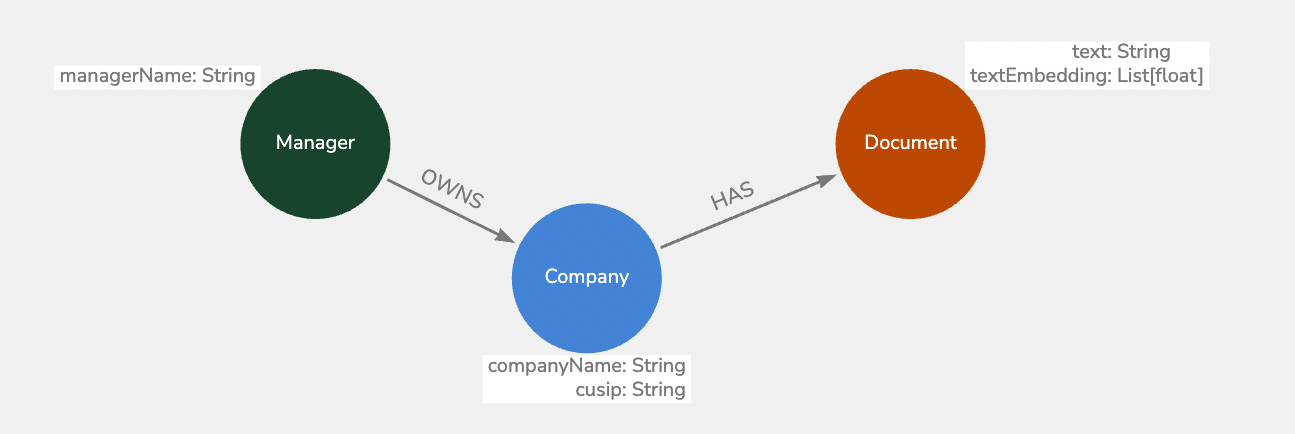

If documents are the entities of interest. For example: "find all documents that talk about pharma related things" then text embeddings with vector similarity search suffices.

But what if we want second or third-order entities related to the documents? For example: "find investors who are most focused on pharma related strategies" how would we efficiently search for them at scale in an enterprise setting?

This is what we demonstrate below. We will also show how you can use graph relationships and Graph Data Science algorithms to further improve search results, especially in common scenarios where the presence of text data is inconsistent or sparse.


## Neo4j Vector Index

We will need to create a vector index for similarity search on Document nodes. Neo4j offers a vector index that enables Approximate Nearest Neighbor Search (ANN). Let's creat an index.

In [46]:
import vertexai
from vertexai.language_models import TextEmbeddingModel

In [47]:
# Creates the vector index
gds.run_cypher("""
CALL db.index.vector.createNodeIndex('document-embeddings', 'Document', 'textEmbedding', 768, 'cosine')
""")

""


In [48]:
# Returns the vector index that has been created
gds.run_cypher(''' 
SHOW INDEXES YIELD name, type, labelsOrTypes, properties, options
WHERE type = "VECTOR"
''')

,name,type,labelsOrTypes,properties,options
0,document-embeddings,VECTOR,[Document],[textEmbedding],"{'indexProvider': 'vector-1.0', 'indexConfig':..."


## Deep Semantic Search with Knoweldge Graph

Now that we have an index. Let’s use it in action. In this case, we will Answer The Question - **"What Investors are most focused in pharma, medicine, and healthcare?"** Remember we do not have documents on investment managers, just companies, and there can be multiple documents for each company.

In [49]:
# Semantic query, lets use these key words to search
semantic_query = ['pharma, medicine, healthcare']

In [50]:
# Create a query vector by embedding the query using Vertex AI text embedding
EMBEDDING_MODEL = TextEmbeddingModel.from_pretrained("textembedding-gecko@001")

In [51]:
# Get query vector
#emb_result =[e.values for e in EMBEDDING_MODEL.get_embeddings(semantic_query)][0]
query_vector = EMBEDDING_MODEL.get_embeddings(semantic_query)[0].values
query_vector[:10]

[0.007500611711293459,
 0.0003618541522882879,
 -0.027530884370207787,
 0.05591048300266266,
 0.040699176490306854,
 -0.04322928935289383,
 0.013355609029531479,
 0.008204770274460316,
 -0.06950043886899948,
 0.02362251654267311]

Now let's use that query vector to search for companies. Remember, companies have multiple documents so we will need to use a graph traversal on top of a document lookup to find which companies are most similar.

In [52]:
# Search for similar companies
res_df = gds.run_cypher("""
CALL db.index.vector.queryNodes('document-embeddings', 1000, $queryVector)
YIELD node AS similarDocuments, score
MATCH (similarDocuments)<-[:HAS]-(c:Company)
RETURN c.companyName as companyName, avg(score) AS score
ORDER BY score DESC LIMIT 100
""", params =  {'queryVector': query_vector})
res_df

,companyName,score
0,MONTEREY BIO ACQUISITION COR,0.854617
1,FORIAN INC,0.850504
2,LANDEC CORP,0.850140
3,Penumbra Inc,0.848445
4,Mesa Laboratories Inc,0.845195
...,...,...
95,"Alphatec Holdings, Inc.",0.837868
96,10X GENOMICS,0.837864
97,Checkpoint Therapeutics,0.837857
98,LENSAR INC,0.837833


You may recognize some of these companies, and if not a quick google search will con firm that their business is involved in healthcare and pharma, so this seems to be working.

Now let's take this one step further and find investment managers who are most heavily focused in pharma. This will involve a bit more Cypher for a 2-hop traversal.

In [53]:
# Search for managers with significiant investments in area
res_df = gds.run_cypher("""
CALL db.index.vector.queryNodes('document-embeddings', 1000, $queryVector)
YIELD node AS similarDocuments, score
MATCH (similarDocuments)<-[:HAS]-(c:Company)
WITH c, avg(score) AS score ORDER BY score LIMIT 100
MATCH (c)<-[r:OWNS]-(m:Manager)
WITH m, r.value as value, score*r.value as weightedScore
WITH m.managerName AS managerName, sum(weightedScore) AS aggScore, sum(value) AS aggValue
RETURN managerName, aggScore/aggValue AS score ORDER BY score DESC LIMIT 1000

""", params =  {'queryVector': query_vector})
res_df

,managerName,score
0,INTERNATIONAL BIOTECHNOLOGY TRUST PLC,0.839136
1,"Old Well Partners, LLC",0.839002
2,Cannell & Co.,0.838979
3,"CI Private Wealth, LLC",0.838979
4,Allworth Financial LP,0.838979
...,...,...
368,Cowen Investment Management LLC,0.831560
369,"Whitefort Capital Management, LP",0.831560
370,"Equitable Holdings, Inc.",0.831560
371,Wealth Alliance,0.831560


And we can see that our top result is a specialized investment trust in Bio-Technology [INTERNATIONAL BIOTECHNOLOGY TRUST PLC](https://ibtplc.com/)

## Similarity: Expanding Available Data for Knowledge Retrieval

Not every element in your data will have rich text data, and further, much like we only have 10K documents for some companies, your use cases may also have incomplete, unevenly distributed text data.

We can check our top result investment manager to this.

In [54]:
gds.run_cypher('''
MATCH (m:Manager {managerName: $managerName})-[:OWNS]->(c:Company)-[:HAS]->(d:Document)
WITH m, count(DISTINCT c) AS ownedCompaniesWithDocs
MATCH (m:Manager {managerName: $managerName})-[:OWNS]->(c:Company)
RETURN m.managerName AS managerName, ownedCompaniesWithDocs, count(DISTINCT c) AS totalOwnedCompanies
''', params =  {'managerName':'INTERNATIONAL BIOTECHNOLOGY TRUST PLC'})

,managerName,ownedCompaniesWithDocs,totalOwnedCompanies
0,INTERNATIONAL BIOTECHNOLOGY TRUST PLC,1,54


This manager has significantly more other companies they own without documents. We can use Graph Data Science Node Similarity to find the managers that have the most overlap to this one which should give us other Biotech companies that we missed due to sparse text data.

In [55]:
g, _  = gds.graph.project('proj', ['Company', 'Manager'], {'OWNS':{'properties':['value']}})

gds.nodeSimilarity.write(g, writeRelationshipType='SIMILAR', writeProperty='score', relationshipWeightProperty='value')

g.drop()

Loading:   0%|          | 0/100 [00:00<?, ?%/s]

NodeSimilarity:   0%|          | 0/100 [00:00<?, ?%/s]

graphName                                                             proj
database                                                             neo4j
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                            21855
relationshipCount                                                  1600322
configuration            {'relationshipProjection': {'OWNS': {'orientat...
density                                                           0.003351
creationTime                           2023-09-22T13:22:54.746567000+01:00
modificationTime                       2023-09-22T13:22:55.687823000+01:00
schema                   {'graphProperties': {}, 'relationships': {'OWN...
schemaWithOrientation    {'graphProperties': {}, 'relationships': {'OWN...
Name: 0, dtype: object

And now we can pull back other relevant results



In [56]:
gds.run_cypher('''
MATCH (m0:Manager {managerName: $managerName})-[r:SIMILAR]->(m:Manager)
RETURN m.managerName AS managerName, r.score AS score
ORDER BY score DESC LIMIT 10
''', params =  {'managerName':'INTERNATIONAL BIOTECHNOLOGY TRUST PLC'})

,managerName,score
0,SECTOR GAMMA AS,0.121268
1,"Sofinnova Investments, Inc.",0.112067
2,SECTORAL ASSET MANAGEMENT INC,0.092490
3,Privium Fund Management B.V.,0.085084
4,BENDER ROBERT & ASSOCIATES,0.078136
5,SPHERA FUNDS MANAGEMENT LTD.,0.071602
6,"AIMZ Investment Advisors, LLC",0.067568
7,GREAT POINT PARTNERS LLC,0.066668
8,HighVista Strategies LLC,0.061513
9,"Slow Capital, Inc.",0.059504


## Clean Up

In [ ]:
gds.set_database('neo4j')
gds.run_cypher('''
MATCH ()-[r:SIMILAR]-()
DELETE r
RETURN count(r)
''')

In [ ]:
gds.run_cypher("""
DROP INDEX `document-embeddings`
""")

In [ ]:
gds.set_database('empty')
gds.run_cypher('''
CALL apoc.schema.assert({}, {})
''')
gds.run_cypher("""
MATCH (n) DETACH DELETE n
""")